In [1]:
# 1. Import lib
import numpy as np
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN


In [2]:
# 2. Read CSV file with close price
df = pd.read_csv('../../Dataset/VCB-Historical-Data_Group-9.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df = df[['Date','Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
# Select only the 'Price' column for scaling
price_data = np.array(df['Price']).reshape(-1,1) 
df = scaler.fit_transform(price_data)


In [4]:
# 4. Split train test
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size:]

In [5]:
# 5.  Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\Windows 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 9. Fit model on train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.8166 - val_loss: 0.1158
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204 - val_loss: 0.1179
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136 - val_loss: 0.0497
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0066 - val_loss: 0.0286
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0229
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048 - val_loss: 0.0170
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0162
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0130
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0108
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0100
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - val_loss: 0.0082
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

In [10]:
# 10. Predict on test data
y_pred=model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [11]:
# 11. Normalize y_pred, y_pred_val
y_pred=scaler.inverse_transform(y_pred)


In [12]:
# 12. Inverse transform the scaled ytest data back to its original scale.
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [13]:
# 13.1. Predict for next 30 days
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output_30=[]
n_steps=30
i=0
while(i<30):
    
    if(len(temp_input)>30):
        x_input=np.array(temp_input[-30:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i=i+1


In [14]:
# 13.2. Predict for next 60 days
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output_60=[]
n_steps=30
i=0
while(i<60):
    
    if(len(temp_input)>30):
        x_input=np.array(temp_input[-30:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i=i+1


In [15]:
# 13.3. Predict for next 90 days
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output_90=[]
n_steps=30
i=0
while(i<90):
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[-30:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i=i+1


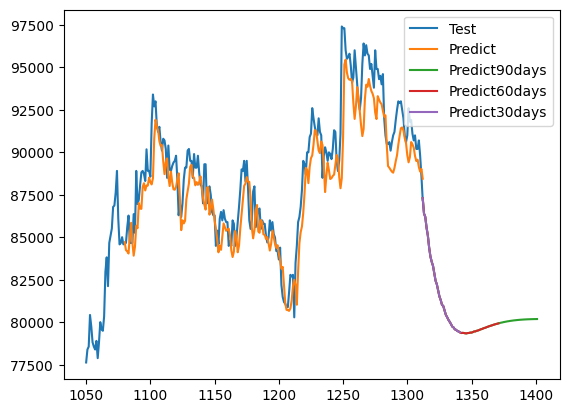

In [16]:

# 14.Vẽ hình

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+30, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
# Next 90 days
prediect_data_index_90 = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 89, step=1)
plt.plot(prediect_data_index_90, scaler.inverse_transform(lst_output_90[:90]))
# Next 60 days
prediect_data_index_60 = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 59, step=1)
plt.plot(prediect_data_index_60, scaler.inverse_transform(lst_output_60[:60]))
# Next 30 days
prediect_data_index_30 = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 29, step=1)
plt.plot(prediect_data_index_30, scaler.inverse_transform(lst_output_30[:30]))
plt.legend([ 'Test', 'Predict', 'Predict90days','Predict60days','Predict30days'])
plt.show()

In [17]:
# 15. Evaluate by RMSE, MAE, MAPE
rmse_value = np.sqrt(np.mean((y_pred - ytest)**2))
mape_value = np.mean(np.abs((ytest - y_pred) / y_pred)) * 100
mae_value = np.mean(np.abs(ytest - y_pred))

print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Error (MAE):", mae_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

Mean Absolute Percentage Error (MAPE): 1.5051408234922827
Mean Absolute Error (MAE): 1326.5244769313306
Root Mean Squared Error (RMSE): 1743.8729344600479
